In [13]:
file = "./trace.h5" 
import pickle
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt



# with h5py.File(file, "r") as hf:
#     trace_array = np.array(hf["trace_array"])
#     textin_array = np.array(hf["textin_array"])
#     textout_array = np.array(hf["textout_array"])

with open('data.pkl', 'rb') as f:
    dict = pickle.load(f)
    trace_array = dict['trace_array']
    textin_array = dict['textin_array']
    textout_array = dict['textout_array']


sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]


print(trace_array.shape)
print(textin_array.shape)
print('plaintext:',textin_array[0])
print('ciphertext:',textout_array[0])

(50, 5250)
(50, 16)
plaintext: [230  58 102 148 193 159 164 126 247  34 214 159 175 125 121 136]
ciphertext: [234 211  44 206 210  15 166 249 175   0  86 225  73 172 156  24]


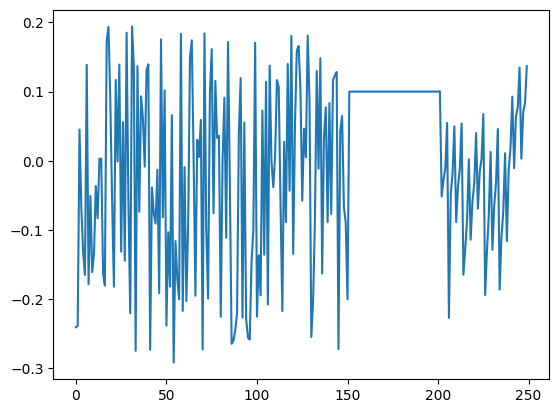

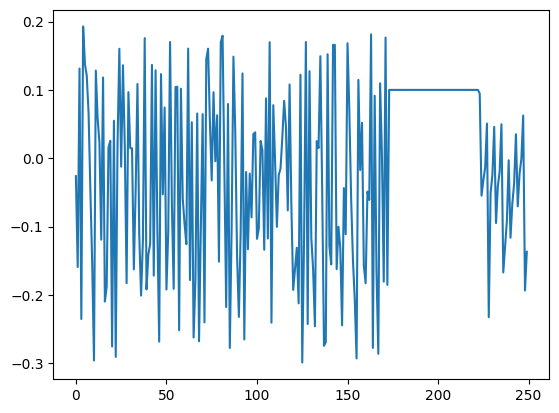

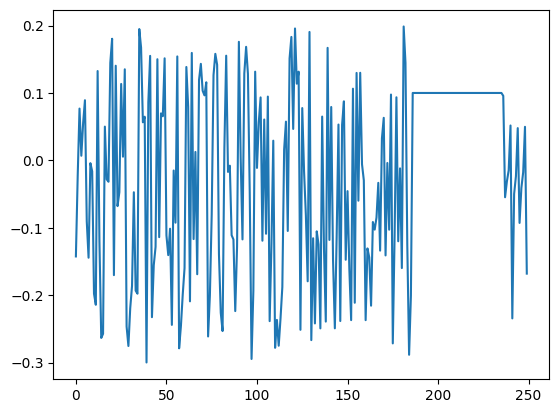

In [14]:
plt.plot(trace_array[0,:250])
plt.show()
plt.plot(trace_array[1, :250])
plt.show()
plt.plot(trace_array[2, :250])
plt.show()

Note that there is a region of constant 0.1 in every trace. This region ends at a different point for every trace. So, we consider the traces starting only from the end point to align them.

In [15]:
# Take only the points after the 0.1 series
new_trace_array = []
for trace in trace_array:
    diff = np.diff(trace)
    start_index = np.where(diff == 0)[0][0]
    end_index = np.where(diff[start_index:] != 0)[0][0] + start_index
    new_trace_array.append(trace[end_index + 1: end_index + 3000])
trace_array = np.array(new_trace_array)

In [16]:
# array to store HammingWeights for all numbers from 0 to 255
HammingWeight = np.array([bin(n).count("1") for n in range(256)])
sbox = np.array(sbox)

"""
Function to calculate the correlation coefficient between the hamming
weight for key_guess of ith bytes of key and the actual power trace
"""
def corr_coeff(key_guess, i):
    hypothetical_power = HammingWeight[sbox[key_guess ^ textin_array[:, i]]]

    hp_mean = np.mean(hypothetical_power, dtype=np.float64)
    traces_mean = np.mean(trace_array, axis=0, dtype=np.float64)

    cov = np.mean((hypothetical_power[:, None] - hp_mean) * (trace_array - traces_mean), axis=0)
    std_prod = np.std(hypothetical_power) * np.std(trace_array, axis=0)

    return cov / std_prod

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:00<00:00, 373.81it/s]


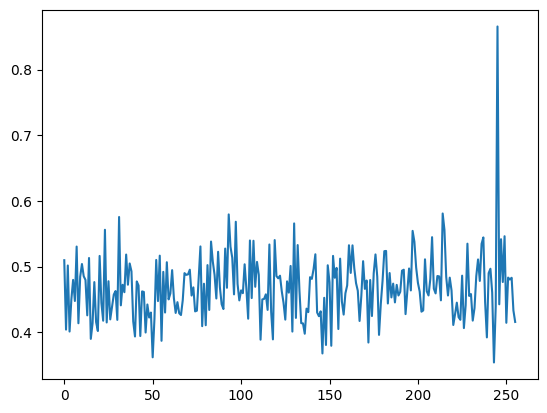

100%|██████████| 256/256 [00:00<00:00, 386.70it/s]


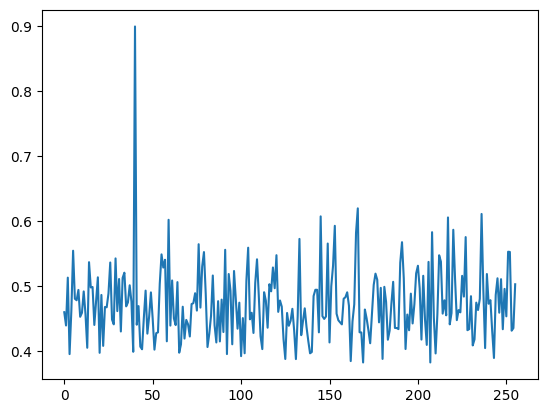

100%|██████████| 256/256 [00:00<00:00, 387.28it/s]


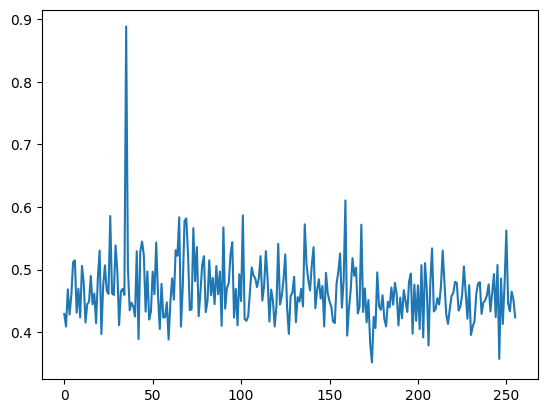

100%|██████████| 256/256 [00:00<00:00, 397.89it/s]


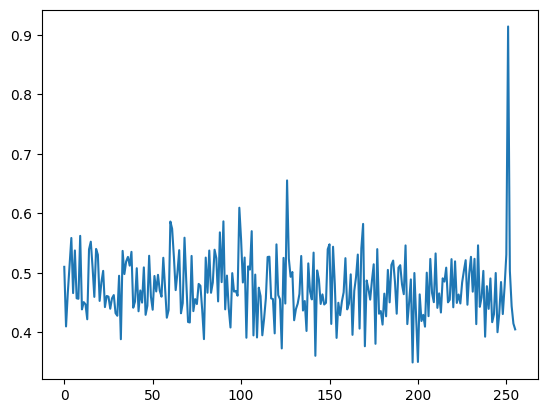

100%|██████████| 256/256 [00:00<00:00, 396.77it/s]


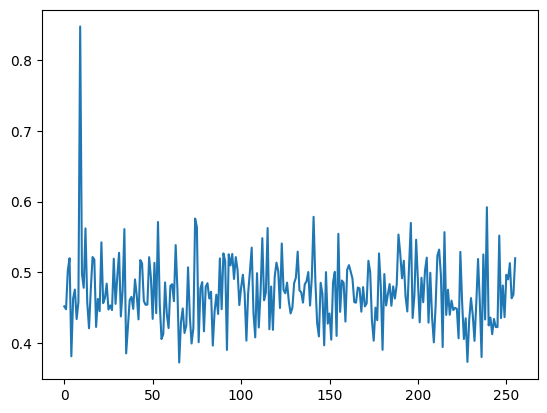

100%|██████████| 256/256 [00:00<00:00, 454.51it/s]


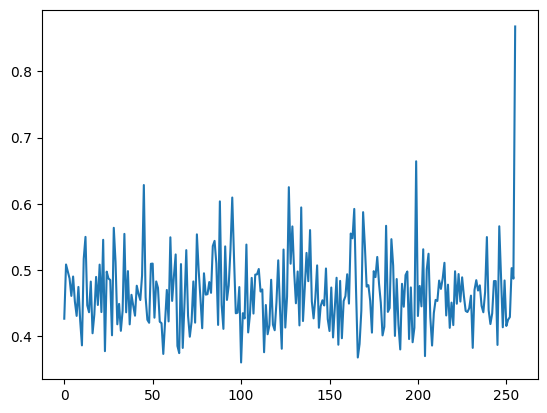

100%|██████████| 256/256 [00:00<00:00, 424.37it/s]


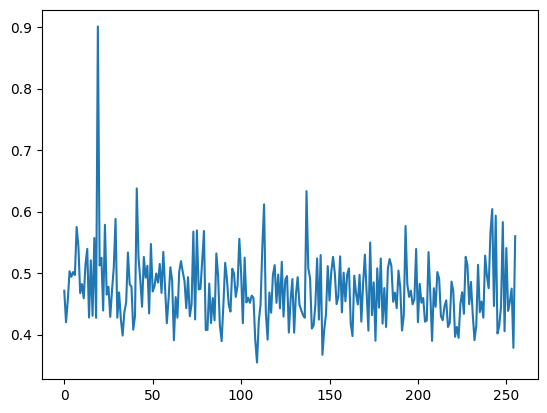

100%|██████████| 256/256 [00:00<00:00, 456.42it/s]


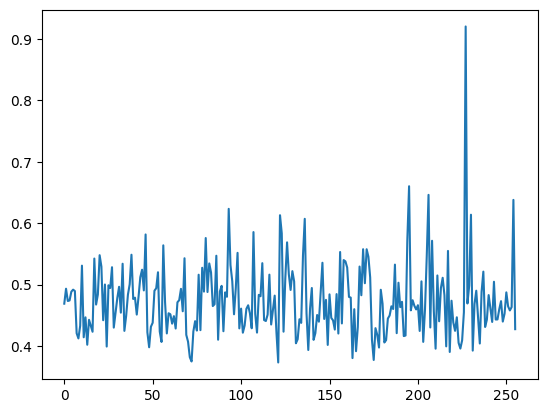

100%|██████████| 256/256 [00:00<00:00, 444.42it/s]


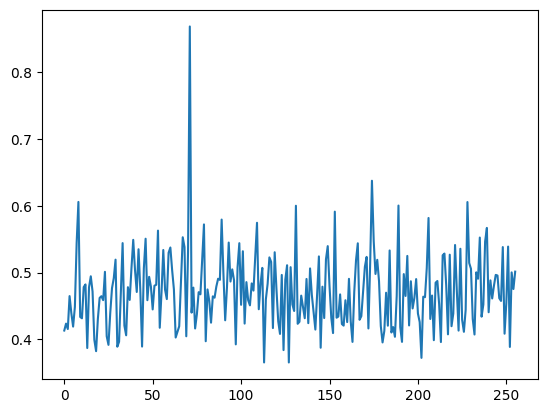

100%|██████████| 256/256 [00:00<00:00, 426.43it/s]


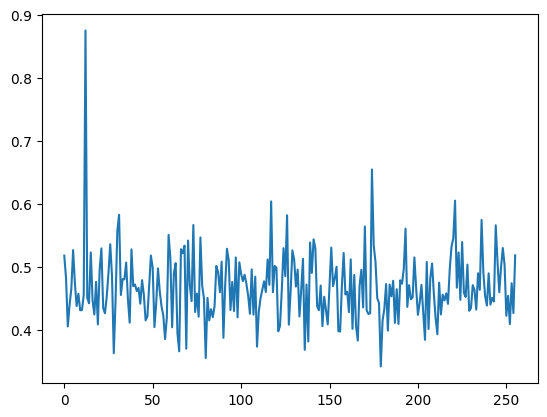

100%|██████████| 256/256 [00:00<00:00, 437.76it/s]


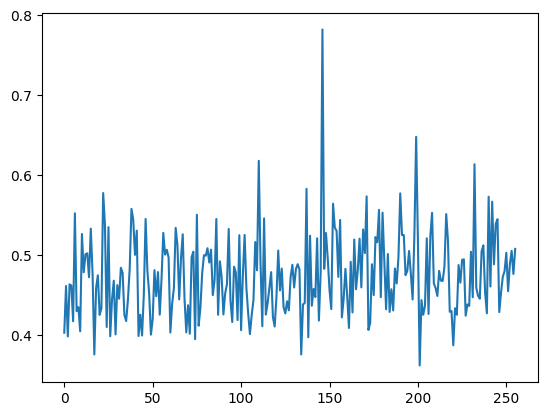

100%|██████████| 256/256 [00:00<00:00, 440.88it/s]


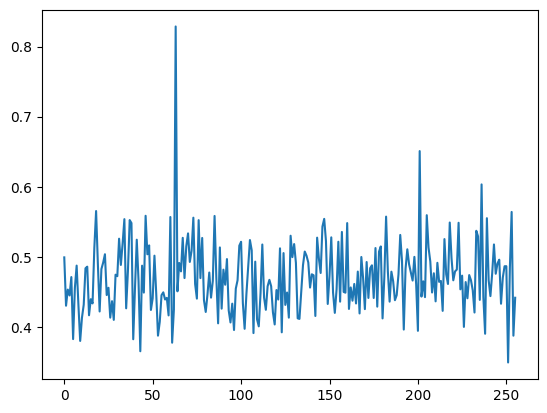

100%|██████████| 256/256 [00:00<00:00, 406.84it/s]


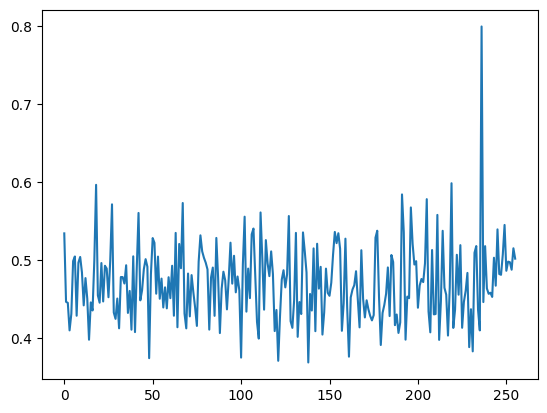

100%|██████████| 256/256 [00:00<00:00, 405.26it/s]


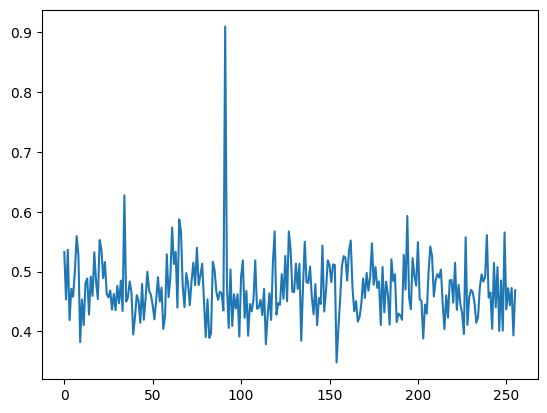

100%|██████████| 256/256 [00:00<00:00, 431.56it/s]


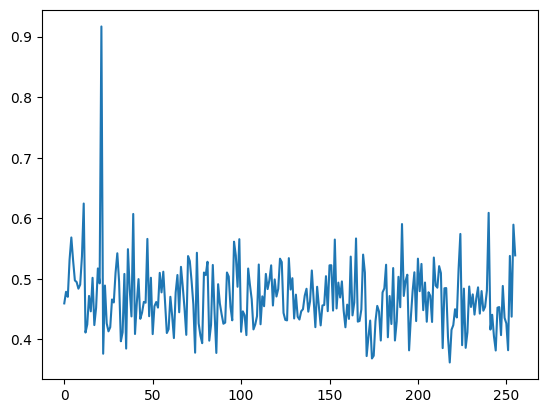

100%|██████████| 256/256 [00:00<00:00, 433.51it/s]


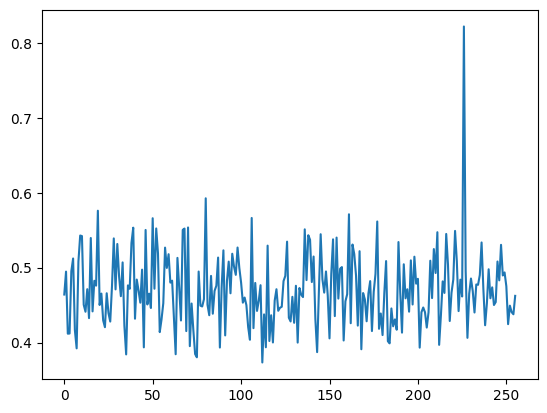

In [17]:
key = np.zeros(16, dtype=np.uint16) # store key guess
# iterate over all key byte indices
for i in range(16):
    max_corrs = np.zeros(256)
    # iterate over all 256 key guesses
    for key_guess in trange(256):
        max_corrs[key_guess] = np.max(np.abs(corr_coeff(key_guess, i)))
    plt.plot(max_corrs)
    plt.show()
    key[i] = np.argmax(max_corrs)

In [19]:
print(key)

print(bytearray(key).hex())

[245  40  35 251   9 255  19 227  71  12 146  63 236  91  21 226]
f50028002300fb000900ff001300e30047000c0092003f00ec005b001500e200
